# SYSC4906 Assignment 2

**Name:** 

**Student number:** 

Portions of this template are based on notebook by Jorge Rodríguez Araújo

    https://medium.com/abraia/first-steps-with-transfer-learning-for-custom-image-classification-with-keras-b941601fcad5

# Step 1: Load the image dataset

In [1]:
#%%capture
from glob import glob

# Load data from SYSC4906 GitHub repo:
!wget https://github.com/jrgreen7/SYSC4906/blob/master/Assignments/Assignment2/SYSC4906_Assig2_Data.zip?raw=true
!unzip -o SYSC4906_Assig2_Data.zip?raw=true

# Get list of filenames for the four datasets:
TRAIN_DIR = 'train'
TEST_DIR = 'test'
trump_train = glob('train/trump/*.jpeg')
trump_test = glob('test/trump/*.jpeg')
decoy_train = glob('train/decoy/*.jpeg')
decoy_test = glob('test/decoy/*.jpeg')


--2019-11-16 02:46:57--  https://github.com/jrgreen7/SYSC4906/blob/master/Assignments/Assignment2/SYSC4906_Assig2_Data.zip?raw=true
Resolving github.com (github.com)... 13.229.188.59
Connecting to github.com (github.com)|13.229.188.59|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/jrgreen7/SYSC4906/raw/master/Assignments/Assignment2/SYSC4906_Assig2_Data.zip [following]
--2019-11-16 02:46:57--  https://github.com/jrgreen7/SYSC4906/raw/master/Assignments/Assignment2/SYSC4906_Assig2_Data.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/Assignments/Assignment2/SYSC4906_Assig2_Data.zip [following]
--2019-11-16 02:46:58--  https://raw.githubusercontent.com/jrgreen7/SYSC4906/master/Assignments/Assignment2/SYSC4906_Assig2_Data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.13

##Deliverable 1: Display the first image in each of the four sets.

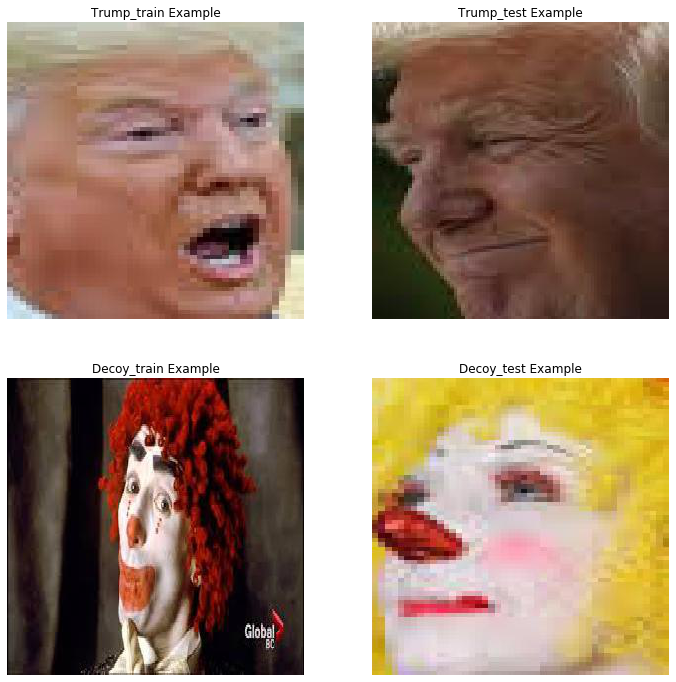

In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

examples = [
    (trump_train[0], "Trump_train"),
    (trump_test[0], "Trump_test"),
    (decoy_train[0], "Decoy_train"),
    (decoy_test[0], "Decoy_test"),
]

f = plt.figure(figsize=(12, 12))

i = 1
for filename, set_name in examples:
    subplt = plt.subplot(2, 2, i)
    subplt.imshow(Image.open(filename))
    subplt.set_title(set_name + " Example")
    subplt.axis("off")
    i += 1

f.show()


# Step 2: Load the original ImageNet-trained Inception v3

In [3]:
from keras.applications.inception_v3 import InceptionV3

# load model
model = InceptionV3(weights="imagenet")

# Display a summary of the model structure:
print(model.summary())


Using TensorFlow backend.















Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________

## Deliverable 2: Number of parameters in layer 'conv2d_1 (Conv2D)'

The conv2d_1 (Conv2D) layer has **864** parameters because there are 3 input image matrices (1 for each colour of RGB), there are 32 output image matrices, and **each filter is 3x3** (9 parameters per filter), so there are *9 x 3 x 32 = 864* parameters in total. 

# Step 3: Test the original ImageNet-trained Inception v3 on our data

In [4]:
from keras.applications.inception_v3 import decode_predictions, preprocess_input
import numpy as np
from keras.preprocessing import image as kp_image

WIDTH = 299
HEIGHT = 299

def predictImgNet(model, img):
    """Run model prediction on an image and decode predictions into 1000 ImageNet classes
    Args:
        model: keras model
        img: PIL format image
    Returns:
        list of predicted labels and their probabilities 
    """
    x = kp_image.img_to_array(img)  # Convert image to nparray
    x = np.expand_dims(x, axis=0)   # Need to pre-pend a dimension to indicate batch number.
    x = preprocess_input(x)         # Normalize image to match how Inceptionv3 expects to receive images
    preds = model.predict(x)        # Use the model to compute prediction score for each possible class
    labels = decode_predictions(preds) # Decodes the output classes back to the original labels for the 1000 ImageNet classes
    return labels[0]

# Clasify 'train/trump/100.jpeg'
label = predictImgNet(model, Image.open("train/trump/100.jpeg"))
print(filename)
print(label)

# Classify 'test/decoy/28.jpeg'
label = predictImgNet(model, Image.open("test/decoy/28.jpeg"))
print(filename)
print(label)



test/decoy/24.jpeg
[('n03814639', 'neck_brace', 0.42603055), ('n04584207', 'wig', 0.08561966), ('n02669723', 'academic_gown', 0.061820034), ('n04591157', 'Windsor_tie', 0.053091396), ('n03884397', 'panpipe', 0.016116196)]
test/decoy/24.jpeg
[('n02883205', 'bow_tie', 0.9346934), ('n04584207', 'wig', 0.046026442), ('n07768694', 'pomegranate', 0.0012600442), ('n04399382', 'teddy', 0.00073105353), ('n03476684', 'hair_slide', 0.0006546819)]


## Deliverable 3: What are the top-ranked predictions  and their scores from the InceptionV3 original model for these two images? 
- for train/trump/100.jpeg, the top-ranked prediction is **"neck_brace"**, with a score of **0.42603055**.
- for test/decoy/28.jpeg, the top-ranked prediction is **"bow_tie"**, with a score of **0.9346934**. 

#Step 4: Transfer Learning. Reload the InceptionV3 CNN, but with a new dense layer. 

In [5]:
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.applications.inception_v3 import InceptionV3, preprocess_input

CLASSES = 2

# Load base model, but ...
base_model = InceptionV3(include_top=False, weights="imagenet")

x = base_model.output
x = GlobalAveragePooling2D(name="avg_pool")(x)
x = Dropout(0.5)(x)
predictions = Dense(CLASSES, activation="softmax", name="predictions")(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"])

print(model.summary())


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_nor

##Deliverable 4: Examine the layers in the full model (see Step 2) and the new modified model using summary(). Which layer has the largest difference in the number of learnable parameters, when comparing the two models? What type of layer is it and why did the number of learnable parameters change?

The **predictions** layer (i.e, the output Dense layer) changes the most. It is reduced from **2049000** parameters down to **4098** because it now only has to differentiate between 2 possible classes instead of 1000, so the layer is now less complex.

#Step 5: Create training and validation image generators to augment image sets

In [6]:
from keras.preprocessing.image import ImageDataGenerator

WIDTH = 299
HEIGHT = 299
BATCH_SIZE = 32

# data prep
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest")

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    fill_mode="nearest")

train_generator = train_datagen.flow_from_directory(
        'train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        'train',
        target_size=(299, 299),
        batch_size=32,
        class_mode='categorical')


Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


##Deliverable 5: Invoke “next” on your training ImageDataGenerator  to create a batch of 32 images and labels (where each label is a tuple). Create a 4rowx8col subplot matrix showing all 32 images. Each image should be titled with its label tuple.

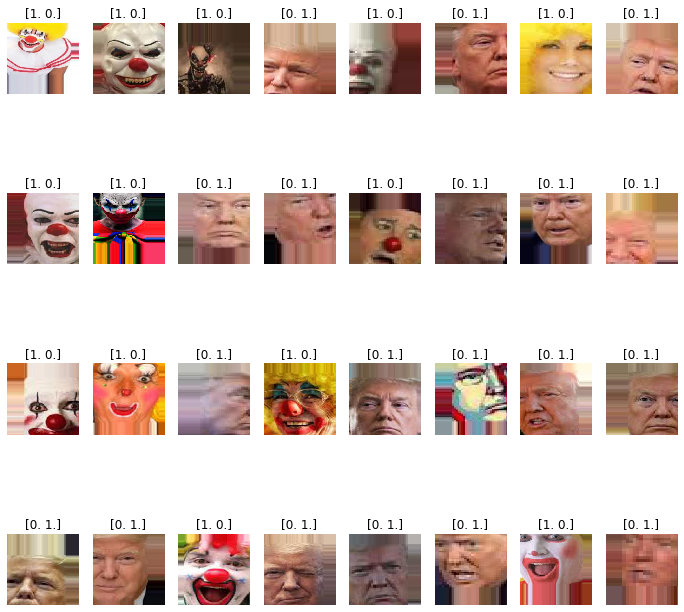

In [7]:
train_X, train_y = train_generator.next()

f = plt.figure(figsize=(12, 12))

for i, (X, y) in enumerate(zip(train_X, train_y)):
    subplt = plt.subplot(4, 8, i + 1)
    subplt.imshow((X + 1) / 2)
    subplt.set_title(str(y))
    subplt.axis("off")

f.show()


#Step 6: Use transfer learning to train the new CNN

In [8]:
EPOCHS = 10
BATCH_SIZE = 32
STEPS_PER_EPOCH = 3
VALIDATION_STEPS = 1

MODEL_FILE = "filename.model"

history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=VALIDATION_STEPS)
  
model.save(MODEL_FILE)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
3/3 [==============================] - 11s 4s/step - loss: 0.8014 - acc: 0.5000 - val_loss: 0.6506 - val_acc: 0.6250
Epoch 2/10
3/3 [==============================] - 1s 500ms/step - loss: 0.6501 - acc: 0.5460 - val_loss: 0.7731 - val_acc: 0.4375
Epoch 3/10
3/3 [==============================] - 1s 480ms/step - loss: 0.6303 - acc: 0.6146 - val_loss: 0.6081 - val_acc: 0.5938
Epoch 4/10
3/3 [==============================] - 1s 429ms/step - loss: 0.5273 - acc: 0.7734 - val_loss: 0.6399 - val_acc: 0.5938
Epoch 5/10
3/3 [==============================] - 1s 429ms/step - loss: 0.5561 - acc: 0.7161 - val_loss: 0.5985 - val_acc: 0.7188
Epoch 6/10
3/3 [==============================] - 2s 589ms/step - loss: 0.4587 - acc: 0.8125 - val_loss: 0.4744 - val_acc: 0.8125
Epoch 7/10
3/3 [==============================] - 2s 538ms/step - loss: 0.4246 - acc: 0.8229 - val_loss: 0.3356 - val_acc: 0.8

##Deliverable 6: Plot the training and validation loss at each training epoch (i.e. the learning curve). Repeat for accuracy instead of loss.

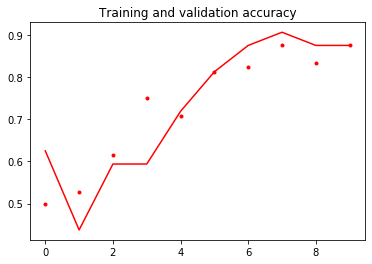

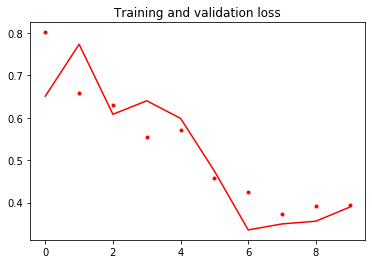

In [9]:
def plot_training(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  
  plt.plot(epochs, acc, 'r.')
  plt.plot(epochs, val_acc, 'r')
  plt.title('Training and validation accuracy')
  
  plt.figure()
  plt.plot(epochs, loss, 'r.')
  plt.plot(epochs, val_loss, 'r-')
  plt.title('Training and validation loss')
  plt.show()
  
plot_training(history)

#Step 7: Test the new CNN

In [0]:
from keras.models import load_model

model = load_model(MODEL_FILE)

In [0]:
from keras.applications.inception_v3 import decode_predictions, preprocess_input
import numpy as np
from keras.preprocessing import image as kp_image

HEIGHT = 299
WIDTH = 299

def predictTrump(model, img):
    """Run model prediction on an image and decode predictions into 1000 ImageNet classes
    Args:
        model: keras model
        img: PIL format image
    Returns:
        Class label with higher predicted probabilities 
    """
    x = kp_image.img_to_array(img)  # Convert image to nparray
    x = np.expand_dims(x, axis=0)   # Need to pre-pend a dimension to indicate batch number.
    x = preprocess_input(x)         # Normalize image to match how Inceptionv3 expects to receive images
    preds = model.predict(x)        # Use the model to compute prediction score for each possible class
    label = 'trump' if preds[0][1]>preds[0][0] else 'decoy' # Decodes the predicted class scores to assign a single class label
    return label

test_files = trump_test + decoy_test
y_true = ['trump'] * len(trump_test) + ['decoy'] * len(decoy_test)
y_pred = []
for filename in test_files:
    img = kp_image.load_img(filename, target_size=(HEIGHT, WIDTH))
    label = predictTrump(model, img)
    y_pred.append(label)



##Deliverable 7: Print confusion matrix and accuracy:

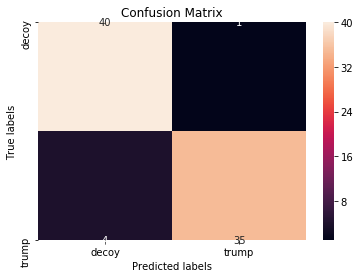

In [12]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to pretty-print confusion matrix. Doesn't work perfectly...
def printCM(cm,labels):
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

  # labels, title and ticks
  ax.set_xlabel('Predicted labels')
  ax.set_ylabel('True labels'); 
  ax.set_title('Confusion Matrix') 
  ax.xaxis.set_ticklabels(labels)
  ax.yaxis.set_ticklabels(labels)
  return

labels = ['decoy', 'trump']
cm = confusion_matrix(y_true, y_pred, labels)
printCM(cm, labels)
